Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

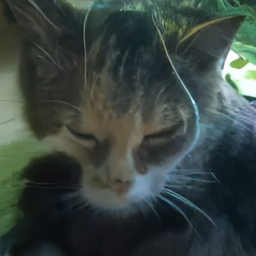

In [5]:
from diffusers import DDPMPipeline

from models.dlgan import DLGAN

ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")
image = ddpm(num_inference_steps=100).images[0]
image

In [6]:
from diffusers import DDPMScheduler, UNet2DModel

scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")

In [7]:
scheduler.set_timesteps(100)

In [8]:
scheduler.timesteps

tensor([990, 980, 970, 960, 950, 940, 930, 920, 910, 900, 890, 880, 870, 860,
        850, 840, 830, 820, 810, 800, 790, 780, 770, 760, 750, 740, 730, 720,
        710, 700, 690, 680, 670, 660, 650, 640, 630, 620, 610, 600, 590, 580,
        570, 560, 550, 540, 530, 520, 510, 500, 490, 480, 470, 460, 450, 440,
        430, 420, 410, 400, 390, 380, 370, 360, 350, 340, 330, 320, 310, 300,
        290, 280, 270, 260, 250, 240, 230, 220, 210, 200, 190, 180, 170, 160,
        150, 140, 130, 120, 110, 100,  90,  80,  70,  60,  50,  40,  30,  20,
         10,   0])

In [9]:
import torch

sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size), device="cuda")

In [11]:
input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

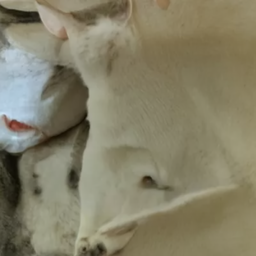

In [12]:
from PIL import Image
import numpy as np

image = (input / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image

In [13]:
num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 16
num_embeddings = 512

commitment_cost = 0.25
sparsity_level = 5

discriminator_factor = 0.01
disc_start = 1000000000

epsilon = 1e-10 # a small number to avoid the numerical issues

In [14]:
torch_device = "cuda"

In [61]:
from PIL import Image
import torch
from transformers import utils, CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from models.dlgan import DLGAN

# vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
vae = DLGAN(in_channels=3,
            num_hiddens=num_hiddens,
            num_residual_hiddens=num_residual_hiddens,
            num_residual_layers=num_residual_layers,
            embedding_dim=4,
            num_embeddings=num_embeddings,
            commitment_cost=commitment_cost,
            sparsity_level=sparsity_level,
            epsilon=epsilon).to(torch_device)
# checkpoint = torch.load(f'../checkpoints/dlgan-odl/epoch_20.pt')
# vae.load_state_dict(checkpoint['model'], strict=False)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True
)
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True
)

In [19]:
# utils.move_cache()

0it [00:00, ?it/s]

In [62]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [ ]:
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

In [48]:
prompt = ["a photograph of an astronaut riding a horse"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.cuda.manual_seed(0)  # Seed generator to create the initial latent noise
batch_size = len(prompt)

In [49]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [50]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

In [51]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [58]:
latents = torch.randn(
    (batch_size, 16, height // 8, width // 8),
    generator=generator,
    device=torch_device,
)

In [59]:
latents = latents * scheduler.init_noise_sigma

In [60]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/25 [00:00<?, ?it/s]

RuntimeError: Given groups=1, weight of size [320, 4, 3, 3], expected input[2, 16, 64, 64] to have 4 channels, but got 16 channels instead

In [57]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae._decoder(latents).sample

RuntimeError: Given groups=1, weight of size [128, 16, 3, 3], expected input[1, 4, 64, 64] to have 16 channels, but got 4 channels instead

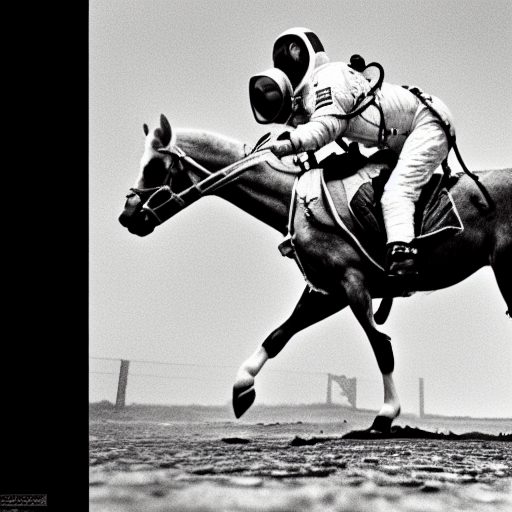

In [40]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image